In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output as co
import seaborn as sns; sns.set()

import sklearn.preprocessing
import sklearn.model_selection

In [2]:
def load_series(path='series/', all=True, n=100):
    filenames = os.listdir(path)
    if all: n = len(filenames)
    series, cnt, n_files = {}, 0, len(filenames)
    freq = range(1, n_files, 10)
    for filename in filenames[:n]:
        cnt+=1
        if cnt in freq: print(f'Files loaded: {cnt}/{n_files}'); co(wait=True)
        series[filename[:-4]] = pd.read_csv(path+filename, index_col=0)
    print(f'Done! Loaded {n_files} files.')
    return series

In [4]:
series = load_series(n=1)

Done! Loaded 1712 files.


In [5]:
data = pd.read_csv('data/historical-database-clean.csv')

# Modelagem Preliminar

### Variáveis disponíveis:
0. Séries temporais originais.
1. Valores passados da mesma série - dois esquemas: "n antes" (cada coluna é a area n anos antes) ou cada coluna um ano fixo (nan para anos futuros).
2. Variações dos valores passados da mesma série.
3. Valores passados de séries diferentes.
4. Tabela com séries concatenadas com atraso de um ano para cada série - Exemplo: tabela com colunas "ano", "variavel alvo" (de uma série), demais séries como colunas, porém atrasadas em um ano. (DESTAQUE)
5. Valores passados de dados externos.
6. Variações dos valores passados de dados externos.

### Tipos de Modelos:
* Modelagem Preliminar:
    1. Regressão simples (variáveis 1., 2., 5. e 6.)
    2. Regressão polinomial ou regressores por série univariada (valores originais)
* Seleção de Modelos:
    3. Regressão polinomial ou regressores por série multivariada (variáveis 4., 5. e 6.) (DESTAQUE)
    4. Univariados por série (valores originais) (DESTAQUE)
    5. Multivariados por série (variáveis 4., 5. e 6.) (DESTAQUE)
    6. Automáticos "pmdarima" (DESTAQUE)

---

## 1. Extraindo variáveis preditivas

In [158]:
X = data.iloc[:, :-1].copy(); X.tail()

,year,city_code,product_type,product
73739,01/01/2013,74d75dde6dc4a5ec,pasture,Livestock
73740,01/01/2014,74d75dde6dc4a5ec,pasture,Livestock
73741,01/01/2015,74d75dde6dc4a5ec,pasture,Livestock
73742,01/01/2016,74d75dde6dc4a5ec,pasture,Livestock
73743,01/01/2017,74d75dde6dc4a5ec,pasture,Livestock


## 2. Extraindo Variável Álvo

In [163]:
target = 'area'
Y = data[target].copy(); Y.head()

#### Substituição de Valores Vazios para Variável Alvo
Y.isna().sum()

#### Substituindo por zero
Y[Y.isna()] = 0

Y.isna().sum()

In [163]:
#### Substituindo pela área média do produto/cidade
n = len(Y)
index_range = range(0, Y.index.values[-1], 500)
isNa = Y.isna()
for index in Y.index:
    if index in index_range:
        co(wait=True); print(f'{index}/{n}')
    if isNa[index]:
        Y[index] = Y [ X['city_code'] == X.loc[index, 'city_code'] ].mean()

In [163]:
#### Salvando variável alvo
# Y.to_csv('target-variable-avg-filled.csv', index=False)

In [163]:
#Y = pd.read_csv('target-variable-avg-filled.csv')['destinated_area']

## 3. Rotulando Variáveis Categóricas

In [164]:
le = sklearn.preprocessing.LabelEncoder

In [165]:
def label_encode(X, base=None):

    if type(base)==type(None): base = X
    X_lab = X.copy()
    for column in X:
        X_lab[column] = le().fit(base[column]).transform(X[column])
    return X_lab

In [166]:
X_lab = label_encode(X, base=X)

## 4. Incluindo dados adicionais

year_area['year'] = le().fit(data['year']).transform(year_area['year'])

year_area['year'] = year_area['year'] + 1

X_prev = pd.merge(X_lab, year_area, on='year', how='left').fillna(0)

#X_prev.to_csv('prev-year-sample.csv')
X_prev = pd.read_csv('prev-year-sample.csv', index_col=0)

X_prev.fillna(0, inplace=True)

## 5. Separação das amostras para treinamento e teste

In [170]:
msk = X_lab['year'].isin([42, 43])
x_t, x_e, y_t, y_e = X_lab[msk==False], X_lab[msk], Y[msk==False], Y[msk]
print('Razão amostras de teste/treinamento:', str(round(len(x_e)/len(x_t)*100, 1))+'%')

Razão amostras de teste/treinamento: 4.9%


## 6. Ajustando Modelo Preliminar

In [171]:
regressors = dict(sklearn.utils.all_estimators('regressor'))
GBR = regressors['GradientBoostingRegressor']

In [172]:
gbr = GBR(verbose=1, n_estimators=1000)

In [173]:
gbr.fit(x_t, y_t)

      Iter       Train Loss   Remaining Time 
         1  1596853248.7475           32.47s
         2  1499287770.9068           32.93s
         3  1420038365.6006           35.38s
         4  1355569398.4105           32.93s
         5  1302954101.9741           30.62s
         6  1259678384.9492           32.79s
         7  1224238471.9885           32.90s
         8  1194946176.4597           31.96s
         9  1170703252.7634           31.68s
        10  1144421026.5471           32.22s
        20   984677383.1335           30.27s
        30   911483715.5234           30.44s
        40   860356193.5264           30.41s
        50   829409392.8799           30.07s
        60   781799941.8787           30.00s
        70   745292474.0864           29.20s
        80   712412812.2863           28.86s
        90   678860398.7919           28.90s
       100   639402238.9037           28.48s
       200   453591144.6926           24.87s
       300   370890060.6941           21.89s
       40

GradientBoostingRegressor(n_estimators=1000, verbose=1)

In [37]:
Y_hat = gbr.predict(x_e)

## 7. Avaliando Modelo Preliminar

In [177]:
metrics = sklearn.metrics._regression

mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score

mae(y_e, Y_hat), mse(y_e, Y_hat), mape(y_e, Y_hat), r2(y_e, Y_hat)

(6963.376389067073,
 836315693.3762583,
 3.149302160686892e+18,
 0.8345141298600727)

## 8. Comparando com Previsão individual

In [184]:
def plot_serie_pred(X, Y, model, city_code, product):

    prod = X[X['product']==product]
    serie = prod[prod['city_code']==city_code].copy()
    serie_lab = label_encode(serie, base=X)
    serie_y = Y.loc[serie.index]
    serie_pred = model.predict(serie_lab)
    serie_df = serie_y.to_frame().set_index(serie['year'].astype('datetime64[D]'))
    serie_df['area pred'] = serie_pred
    serie_df.plot(marker='o', lw=3)

In [187]:
def fit_plot_serie_pred(X, Y, model, city_code, product, horizon=2, seed=0):
    
    prod = X[X['product']==product]
    serie = prod[prod['city_code']==city_code].copy()
#     serie = series[city_code+'-'+product].reset_index()
    serie['year'] = serie['year'].astype('datetime64[Y]')
    serie_lab = label_encode(serie, base=X)
    serie_y = Y.loc[serie.index]
    msk = serie_lab['year'].isin(serie_lab['year'].sort_values().iloc[-horizon:])
    x_t, x_e, y_t, y_e = serie_lab[msk==False], serie_lab[msk], serie_y[msk==False], serie_y[msk]
    model.fit(x_t, y_t)
    serie_pred = model.predict(serie_lab)
    serie_df = serie_y.to_frame().set_index(serie['year'].astype('datetime64[D]'))
    serie_df['area pred'] = serie_pred
    serie_df['area'].plot(lw=5)
    serie_df['area pred'].plot(marker='o')

In [ ]:
city, prod = [X.sample(1).iloc[0][col] for col in ['city_code', 'product']]

In [181]:
city, prod = np.random.choice(list(series.keys())).split('-'); city, prod

('fda49275fbf5caf6', 'Cocoa')

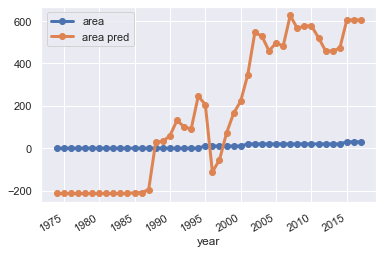

In [185]:
plot_serie_pred(X, Y, gbr, city_code=city, product=prod)

In [ ]:
fit_plot_serie_pred(X, Y, GBR(n_estimators=50, verbose=0), city_code=city, product=prod, horizon=2)

## 9. Visualizando Performance

#### Parametros do Modelo

In [189]:
fi = pd.DataFrame(gbr.feature_importances_, index=X.columns, columns=['feature_importance'])

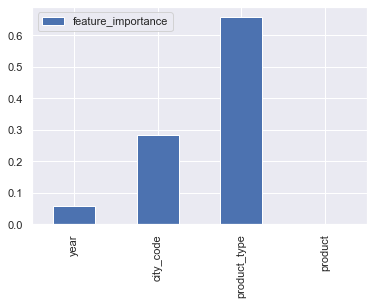

In [190]:
fi.plot.bar()

#### Performance geral do modelo

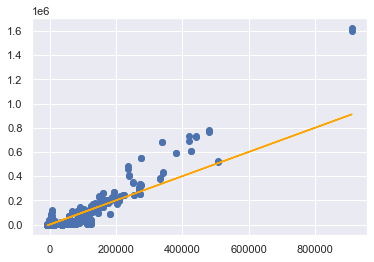

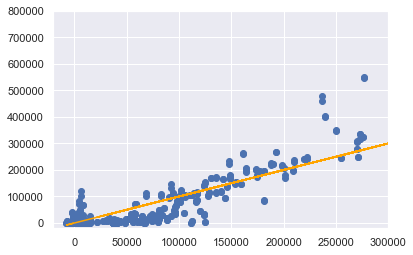

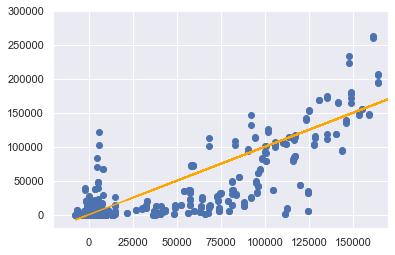

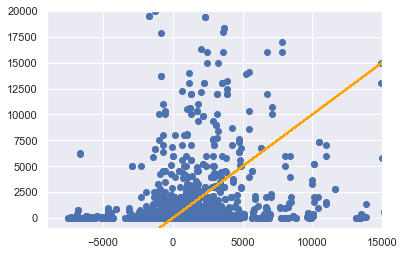

In [193]:
plt.scatter(Y_hat, y_e)
plt.plot(Y_hat, Y_hat, color='orange')
plt.show()
#plt.xlim(-20000, 300000)
#plt.ylim(-20000, 800000)

plt.scatter(Y_hat, y_e)
plt.plot(Y_hat, Y_hat, color='orange')
plt.xlim(-20000, 300000)
plt.ylim(-20000, 800000)
plt.show()

plt.scatter(Y_hat, y_e)
plt.plot(Y_hat, Y_hat, color='orange')
plt.xlim(-20000, 170000)
plt.ylim(-20000, 300000)
plt.show()

plt.scatter(Y_hat, y_e)
plt.plot(Y_hat, Y_hat, color='orange')
plt.xlim(-9000, 15000)
plt.ylim(-1000, 20000)
plt.show()

#### Comparando Real com Previsão

In [191]:
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

In [192]:
colors = ['blue', 'orange', 'green', 'yellow', 'red', 'purple', 'brown', 'pink', 'grey', 'lightblue', 'lightgreen', 'violet', 'darkblue']